# Import important libraries

In [192]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import random

## 0. Reusable function

In [193]:
def visualize_dataset(dataset, ordNumberOfAssignment: int):
    """
    Visualizes a 2D dataset using a scatter plot.

    Args:
        dataset (numpy.ndarray): A numpy array of shape (n, 2) containing the data points.
    """
    plt.figure(figsize=(8, 6)) 
    plt.scatter(dataset[:, 0], dataset[:, 1], s=10)
    plt.title('Toy Dataset Visualization')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.savefig(f'img/{ordNumberOfAssignment}_unclustered_dataset.png')
    plt.show()

In [194]:
def visualize_clusters(clusters, ordNumberOfAssignment: int):
    """
    Visualizes clusters with their points and centroids.

    Parameters:
        clusters (dict): A dictionary where each key is a cluster ID and the value is a dict
                         with 'centroid' (2-element list) and 'points' (list of 2D arrays).
    """
    plt.figure(figsize=(10, 8))
    
    colors = plt.cm.get_cmap('tab10', len(clusters))  # Get distinct colors

    for idx, (cluster_id, data) in enumerate(clusters.items()):
        points = np.array(data['points'])
        centroid = np.array(data['centroid'])

        plt.scatter(points[:, 0], points[:, 1], s=30, label=f'Cluster {cluster_id}', color=colors(idx))
        plt.scatter(centroid[0], centroid[1], c='black', s=100, marker='X', edgecolor='white', linewidth=1.5, label=f'Centroid {cluster_id}')

    plt.title('Cluster Visualization')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'img/{ordNumberOfAssignment}_clustered_dataset.png')
    plt.show()

## Assignment 01

### 1.1. Task 01
Generate a toy dataset having $600$ data points, $200$ points of them following the Gaussian distribution $\mathcal{N}((2, 2), \Sigma)$, $200$ points of them following the Gaussian distribution $\mathcal{N}((8, 3), \Sigma)$, and $200$ points of them following the Gaussian distribution $\mathcal{N}((3, 6), \Sigma)$ where $\Sigma = 
\left(\begin{array}{cc}
    1 & 0 \\
    0 & 1
\end{array}\right)
$.

In [195]:
def generate_dataset():
    """
    Generates a toy dataset with 600 data points from three Gaussian distributions.

    The dataset consists of:
    - 200 points from N((2, 2), Sigma)
    - 200 points from N((8, 3), Sigma)
    - 200 points from N((3, 6), Sigma)
    where Sigma is the 2x2 identity matrix.

    Returns:
        numpy.ndarray: A numpy array of shape (600, 2) containing the generated data points.
    """
    # Define the means for the three Gaussian distributions
    mean1 = np.array([2, 2])
    mean2 = np.array([8, 3])
    mean3 = np.array([3, 6])

    covariance = np.array([[1, 0], [0, 1]])
    num_points_per_cluster = 200

    # Generate data points from the 1st, 2nd, 3rd Gaussian distribution
    data_cluster1 = np.random.multivariate_normal(mean1, covariance, num_points_per_cluster)
    data_cluster2 = np.random.multivariate_normal(mean2, covariance, num_points_per_cluster)
    data_cluster3 = np.random.multivariate_normal(mean3, covariance, num_points_per_cluster)

    # Concatenate the data from the three clusters
    toy_dataset = np.concatenate((data_cluster1, data_cluster2, data_cluster3), axis=0)

    return toy_dataset

In [196]:
dataset1 = generate_dataset()
dataset1

array([[ 1.60477752,  1.26618492],
       [ 1.85304736, -0.96285113],
       [ 3.27658803,  3.91416917],
       ...,
       [ 3.62544132,  5.99392731],
       [ 2.51041974,  4.86508202],
       [ 4.83866143,  5.36178594]], shape=(600, 2))

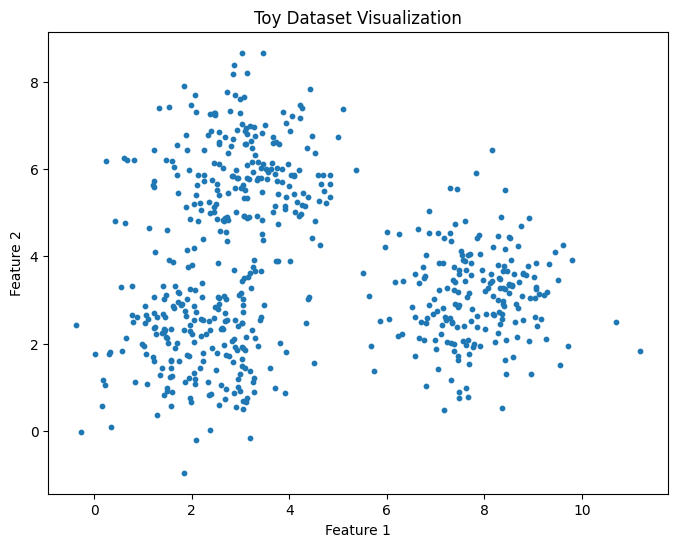

In [197]:
visualize_dataset(dataset=dataset1, ordNumberOfAssignment=1)

### 1.2. Task 02
- Use Numpy only to implement the K-means method for finding three clusters from the toy dataset.
- Train this K-means with EM method.

In [198]:
clustered_dataset1 = {
    0: {'list': [dataset1[0]], 'centroid': dataset1[0]},
    1: {'list': [dataset1[1]], 'centroid': dataset1[1]},
    2: {'list': [dataset1[2]], 'centroid': dataset1[2]},
}
for cluster in clustered_dataset1:
    print(cluster)

0
1
2


In [199]:
def calculate_distance(pointA: list[float], pointB: list[float]) -> float:
    """
    Calculates the Euclidean distance between two points.
    Assumes points are lists of floats of the same dimension.
    """
    if len(pointA) != len(pointB):
        raise ValueError("Points must have the same dimension.")
    squared_diffs = [(a - b)**2 for a, b in zip(pointA, pointB)]
    return sum(squared_diffs)**0.5


calculate_distance([0, 0], [3, 4])

5.0

In [200]:
def find_nearestCluster(_datapoint: list[float], _clusters: dict) -> int:
    """
    Finds the ID of the cluster whose centroid is closest to the given datapoint.
    _clusters is a dictionary where keys are cluster IDs (e.g., 0, 1, 2)
    and values are dictionaries containing 'centroid' (list of floats)
    and 'points' (list of datapoints assigned to it).
    """
    min_distance = float('inf')
    nearest_cluster_id = -1
    for cluster_id, cluster_data in _clusters.items():
        centroid = cluster_data['centroid']
        distance = calculate_distance(_datapoint, centroid)
        if distance < min_distance:
            min_distance = distance
            nearest_cluster_id = cluster_id
    return nearest_cluster_id


In [201]:
def update_latestCentroid(data_list: list[list[float]]) -> list[float]:
    """
    Calculates the new centroid (mean) for a list of data points.
    Assumes all data points in data_list have the same dimension.
    Returns a list of floats representing the new centroid.
    """
    if not data_list:
        # Handle empty cluster, perhaps return None or the previous centroid
        # For K-Means, typically an empty cluster indicates a problem or
        # that the cluster should be removed or reinitialized.
        # For simplicity, we'll return an empty list or raise an error.
        return []
        
    num_dimensions = len(data_list[0])
    new_centroid = [0.0] * num_dimensions
    for datapoint in data_list:
        for i in range(num_dimensions):
            new_centroid[i] += datapoint[i]
    
    num_points = len(data_list)
    return [coord / num_points for coord in new_centroid]

In [202]:
def implement_kMeans_assignment1(dataset: list[list[float]], numberOfClusters: int = 3, max_iterations: int = 100) -> dict:
    '''
    Implements the K-Means clustering algorithm for Assignment 1.

    The algorithm follows these steps:
    1.  **Initialization**: Randomly selects `numberOfClusters` data points from the
        `dataset` as initial centroids.
    2.  **Iterative Process** (until convergence or max_iterations):
        a.  **Assignment Step**: Assigns each data point in the `dataset` to the
            nearest centroid.
        b.  **Update Step**: Recalculates the centroids based on the mean of all
            data points assigned to each cluster.
        c.  **Convergence Check**: Determines if the centroids have moved significantly.
            If not, the algorithm is considered converged.

    Args:
        dataset (list[list[float]]): A list of data points, where each data point
                                     is represented as a list of floats.
        numberOfClusters (int): The desired number of clusters (k). Default is 3.
        max_iterations (int): The maximum number of iterations to run the algorithm.
                              Default is 100.

    Returns:
        dict: A dictionary where keys are cluster IDs (integers, 0 to k-1) and
              values are dictionaries containing:
              - 'centroid': The final centroid of the cluster (list of floats).
              - 'points': A list of data points assigned to that cluster.
    '''

    # Step 1: Initialize centroids randomly
    # Select 'numberOfClusters' unique random data points from the dataset as initial centroids.
    initial_centroid_indices = random.sample(range(len(dataset)), numberOfClusters)
    
    clusters = {}
    for i, idx in enumerate(initial_centroid_indices):
        clusters[i] = {
            'centroid': list(dataset[idx]),  # Make a copy to avoid modifying original dataset point
            'points': []                     # Initially empty, filled in assignment step
        }

    # Iterate until convergence or max_iterations
    for iteration in range(max_iterations):
        # Store old centroids to check for convergence later
        old_centroids = {k: list(v['centroid']) for k, v in clusters.items()} 

        # Step 2a: Assignment Step - Assign each data point to the nearest cluster
        # Create a new structure for the current iteration's assignments
        new_assignments = {i: [] for i in range(numberOfClusters)}
        
        for datapoint in dataset:
            cluster_id = find_nearestCluster(datapoint, clusters)
            new_assignments[cluster_id].append(datapoint)
        
        # Step 2b: Update Step - Recalculate centroids
        converged = True
        for cluster_id, points_in_cluster in new_assignments.items():
            if points_in_cluster:  # Only update if the cluster has points assigned
                new_centroid = update_latestCentroid(points_in_cluster)
                # Check for convergence *while* updating
                if calculate_distance(old_centroids[cluster_id], new_centroid) > 1e-6: # Small threshold for floating point comparison
                    converged = False
                clusters[cluster_id]['centroid'] = new_centroid
            else:
                # If a cluster becomes empty, its centroid won't move based on points.
                # In robust implementations, you might reinitialize such a centroid.
                # For simplicity here, we consider it not converged if it was previously non-empty
                # and now has no new points to update from, implying its position might still be suboptimal.
                # For convergence check, if its centroid hasn't moved from old_centroids, it's fine.
                pass # Keep old centroid if cluster is empty, and it won't affect convergence check if old and new are same.
                
            # Update the points list in the main clusters dictionary for the next iteration/final output
            clusters[cluster_id]['points'] = points_in_cluster

        # Step 2c: Check for convergence
        if converged:
            print(f"K-Means converged after {iteration + 1} iterations.")
            break
    else:
        print(f"K-Means reached maximum iterations ({max_iterations}) without converging.")

    return clusters

K-Means converged after 5 iterations.


C:\Users\VICTUS\AppData\Local\Temp\ipykernel_1740\591568061.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(clusters))  # Get distinct colors


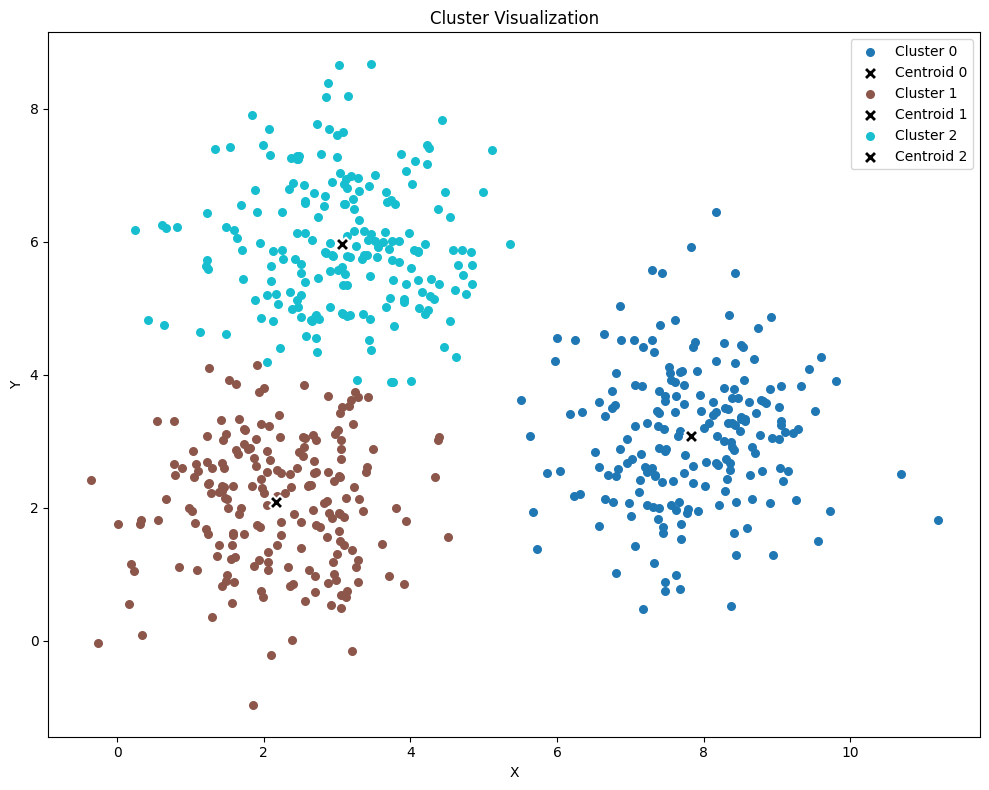

{0: {'centroid': [np.float64(7.831065070236012),
   np.float64(3.0724203112944117)],
  'points': [array([8.94924807, 1.29532941]),
   array([6.33570845, 3.44086573]),
   array([8.2865285 , 2.25199909]),
   array([6.83364756, 2.58333297]),
   array([7.12980259, 2.42205597]),
   array([8.56430494, 3.33185303]),
   array([8.80079912, 3.6008888 ]),
   array([8.1635985 , 3.44490204]),
   array([7.17216026, 4.41586771]),
   array([7.29786329, 2.59574086]),
   array([5.62631688, 3.08417493]),
   array([8.12671267, 3.59748983]),
   array([8.34798123, 4.90102365]),
   array([6.69808297, 2.49348889]),
   array([9.02942305, 3.0374097 ]),
   array([7.69629194, 4.0596497 ]),
   array([7.11202938, 2.22937804]),
   array([8.46604062, 3.65524797]),
   array([7.88037232, 4.49693121]),
   array([8.61312824, 3.58351645]),
   array([8.02534181, 2.68385384]),
   array([6.75242259, 3.50317096]),
   array([6.17561433, 3.4170396 ]),
   array([7.17159343, 0.47149963]),
   array([8.2804463 , 3.00042716]),
   ar

In [203]:
cluster1 = implement_kMeans_assignment1(dataset1)
visualize_clusters(clusters=cluster1, ordNumberOfAssignment=1)
cluster1

### Task 1.3.
- Give comments on the effect of intializing centroids randomly to the overall performance of K-means.

The initial placement of centroids in K-means can significantly impact the final clustering results. Because K-means uses an iterative process to assign points to the nearest centroid and update the centroids based on current assignments, starting with different initial centroids can lead to different clusters.

If the initial centroids are chosen poorly (for example, too close to each other or far from the actual cluster centers), K-means may:

Converge slowly, requiring more iterations to find a solution.

Get stuck in a local minimum, producing suboptimal clusters that don’t represent the true structure of the data well.

Result in imbalanced or incorrect cluster assignments.

On the other hand, a good random initialization, where centroids are well spread out and closer to the true cluster centers, helps K-means converge faster and find better clusters.

Because of this sensitivity, methods like running K-means multiple times with different random starts or using smarter initialization strategies (e.g., K-means++) are often used to improve performance and stability.

## Assignment 02

### Task 2.1.
- Generate a toy dataset having $50$ points following the Gaussian distribution $\mathcal{N}((2, 2), \Sigma)$, $20$ points of them following the Gaussian distribution $\mathcal{N}((8, 3), \Sigma)$, and $1000$ points of them following the Gaussian distribution $\mathcal{N}((3, 6), \Sigma)$ where $\Sigma = 
\left(\begin{array}{cc}
    1 & 0 \\
    0 & 1
\end{array}\right)
$.

In [204]:
def generate_dataset2():
    """
    Generates a toy dataset with 1070 data points from three Gaussian distributions.

    The dataset consists of:
    - 50 points from N((2, 2), Sigma)
    - 20 points from N((8, 3), Sigma)
    - 1000 points from N((3, 6), Sigma)
    where Sigma is the 2x2 identity matrix.

    Returns:
        numpy.ndarray: A numpy array of shape (1070, 2) containing the generated data points.
    """
    # Define the means for the three Gaussian distributions
    mean1 = np.array([2, 2])
    mean2 = np.array([8, 3])
    mean3 = np.array([3, 6])

    covariance = np.array([[1, 0], [0, 1]])
    num_points_per_cluster = [50, 20, 1000]

    # Generate data points from the 1st, 2nd, 3rd Gaussian distribution
    data_cluster1 = np.random.multivariate_normal(mean1, covariance, num_points_per_cluster[0])
    data_cluster2 = np.random.multivariate_normal(mean2, covariance, num_points_per_cluster[1])
    data_cluster3 = np.random.multivariate_normal(mean3, covariance, num_points_per_cluster[2])

    # Concatenate the data from the three clusters
    toy_dataset = np.concatenate((data_cluster1, data_cluster2, data_cluster3), axis=0)

    return np.array(toy_dataset)

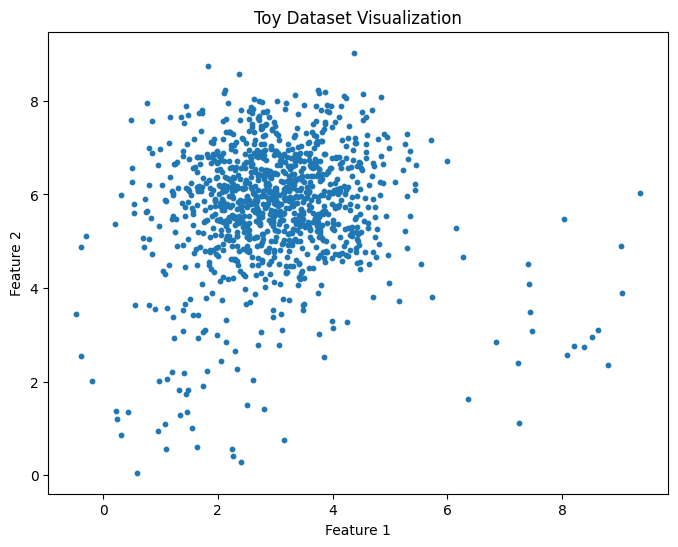

In [205]:
dataset2 = generate_dataset2()
visualize_dataset(dataset2, ordNumberOfAssignment=2)

### Task 2.2.
- Use Numpy only to implement the K-means method for finding three clusters from the toy dataset.
- Train this K-means with EM method.

In [206]:
def implement_kMeans_assignment02(dataset: list[list[float]], numberOfClusters: int = 3, max_iterations: int = 100) -> dict:
    '''
    Implements the K-Means clustering algorithm.

    Args:
        dataset (list[list[float]]): A list of data points, where each data point is a list of floats.
        numberOfClusters (int): The desired number of clusters (k).
        max_iterations (int): The maximum number of iterations to run the algorithm.

    Returns:
        dict: A dictionary where keys are cluster IDs (integers) and values are
              dictionaries containing:
              - 'centroid': The final centroid of the cluster (list of floats).
              - 'points': A list of data points assigned to that cluster.
    '''

    # Step 1: Initialize centroids randomly
    # Select 'numberOfClusters' random data points from the dataset as initial centroids.
    # It's good practice to ensure unique initial centroids.
    initial_centroid_indices = random.sample(range(len(dataset)), numberOfClusters)
    
    clusters = {}
    for i, idx in enumerate(initial_centroid_indices):
        clusters[i] = {
            'centroid': list(dataset[idx]),  # Make a copy to avoid modifying original dataset
            'points': []
        }

    # Iterate until convergence or max_iterations
    for iteration in range(max_iterations):
        # Step 2: Assignment Step - Assign each data point to the nearest cluster
        # Create a new structure for the current iteration's assignments
        new_clusters_points = {i: [] for i in range(numberOfClusters)}
        
        for datapoint in dataset:
            cluster_id = find_nearestCluster(datapoint, clusters)
            new_clusters_points[cluster_id].append(datapoint)
        
        # Step 3: Update Step - Recalculate centroids
        old_centroids = {k: list(v['centroid']) for k, v in clusters.items()} # Copy old centroids
        
        for cluster_id, points_in_cluster in new_clusters_points.items():
            if points_in_cluster:  # Only update if the cluster has points
                new_centroid = update_latestCentroid(points_in_cluster)
                clusters[cluster_id]['centroid'] = new_centroid
            else:
                # Handle empty cluster: you might reinitialize its centroid
                # or keep the old one. For now, we'll just keep the old one
                # if the cluster becomes empty, as a simple approach.
                pass 
                
        # Update the points in the main clusters dictionary
        for cluster_id, points_in_cluster in new_clusters_points.items():
            clusters[cluster_id]['points'] = points_in_cluster

        # Check for convergence: if centroids don't change significantly
        converged = True
        for cluster_id, old_centroid in old_centroids.items():
            if calculate_distance(old_centroid, clusters[cluster_id]['centroid']) > 1e-6: # Small threshold for float comparison
                converged = False
                break
        
        if converged:
            print(f"K-Means converged after {iteration + 1} iterations.")
            break
    else:
        print(f"K-Means reached maximum iterations ({max_iterations}) without converging.")

    return clusters

In [207]:
cluster2 = implement_kMeans_assignment02(dataset=dataset2, numberOfClusters=5, max_iterations=100)
cluster2

K-Means converged after 58 iterations.


{0: {'centroid': [np.float64(1.6197810513920003),
   np.float64(2.4087349281296953)],
  'points': [array([0.80346813, 3.62738467]),
   array([1.77752617, 3.10288041]),
   array([0.58659835, 0.05382199]),
   array([3.85079632, 2.51768825]),
   array([1.1995394 , 2.19898369]),
   array([2.30476745, 2.64713901]),
   array([-0.38842029,  2.5535148 ]),
   array([2.50452034, 1.49503208]),
   array([-0.19016481,  2.01269211]),
   array([1.39406658, 3.08390252]),
   array([2.744655  , 3.05654282]),
   array([2.40324879, 0.27782197]),
   array([0.95726687, 0.94499658]),
   array([2.69417599, 2.78867096]),
   array([1.07645463, 1.10369714]),
   array([1.51115399, 3.76075666]),
   array([1.63884533, 0.60120745]),
   array([3.11183146, 3.09365975]),
   array([1.45730898, 1.34186117]),
   array([2.05479543, 2.43463656]),
   array([2.61281827, 2.02826463]),
   array([1.54675159, 1.01025809]),
   array([3.06269788, 2.77646846]),
   array([2.27298582, 0.41964436]),
   array([1.10104179, 0.5548896 ]),


C:\Users\VICTUS\AppData\Local\Temp\ipykernel_1740\591568061.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(clusters))  # Get distinct colors


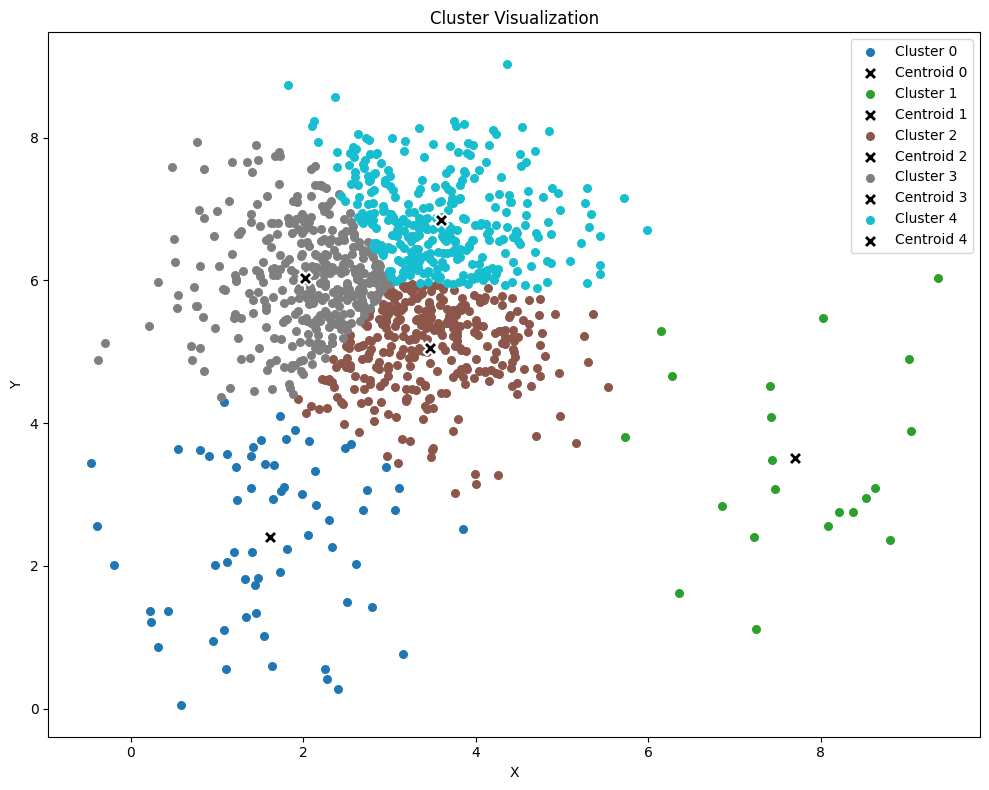

In [208]:
visualize_clusters(clusters=cluster2, ordNumberOfAssignment=2)

### Task 2.3.
- Give comments on the effect of different sizes among clusters to the performance of K-means.

K-means treats all points equally when calculating cluster centers, so clusters with many points have a bigger influence on where the centroids end up.

Because the third cluster here has 1000 points, much more than the others, it tends to dominate the clustering process. This can cause the centroids of the smaller clusters to be pulled toward the large cluster’s data, making it harder for K-means to accurately separate the smaller clusters.

In other words, when cluster sizes differ a lot, K-means might bias towards fitting the biggest cluster well but misclassify points from smaller clusters. This can lead to poor performance and incorrect clustering, especially when some clusters are tiny compared to others.

## Assignment 03

### Task 3.1.
- Generate a toy dataset having $600$ data points, $200$ points of them following the Gaussian distribution $\mathcal{N}((2, 2), \Sigma_1)$, $200$ points of them following the Gaussian distribution $\mathcal{N}((8, 3), \Sigma_1)$, and $200$ points of them following the Gaussian distribution $\mathcal{N}((3, 6), \Sigma_2)$ where 

$$
    \Sigma_1 = 
    \left(\begin{array}{cc}
        1 & 0 \\
        0 & 1
    \end{array}\right)
$$ 

and

$$
\Sigma_2 = 
    \left(\begin{array}{cc}
        10 & 0 \\
        0 & 1
    \end{array}\right)
$$.

In [209]:
def generate_dataset3() -> np.ndarray:
    mu1 = np.array([2, 2])
    mu2 = np.array([8, 3])
    mu3 = np.array([3, 6])

    # Define the covariance matrices
    # Sigma_1 (Identity matrix - standard deviation of 1 in both x and y, no correlation)
    Sigma1 = np.array([
        [1, 0],
        [0, 1]
    ])

    # Sigma_2 (Standard deviation of sqrt(10) in x, 1 in y, no correlation)
    Sigma2 = np.array([
        [10, 0],
        [0, 1]
    ])

    # Number of points for each cluster
    num_points_per_cluster = 200

    # Generate points for the first cluster
    # np.random.seed(42) # Optional: for reproducibility
    cluster1_points = np.random.multivariate_normal(mu1, Sigma1, num_points_per_cluster)

    # Generate points for the second cluster
    cluster2_points = np.random.multivariate_normal(mu2, Sigma1, num_points_per_cluster)

    # Generate points for the third cluster
    cluster3_points = np.random.multivariate_normal(mu3, Sigma2, num_points_per_cluster)

    # Concatenate all generated points into a single dataset
    toy_dataset = np.vstack((cluster1_points, cluster2_points, cluster3_points))

    return toy_dataset

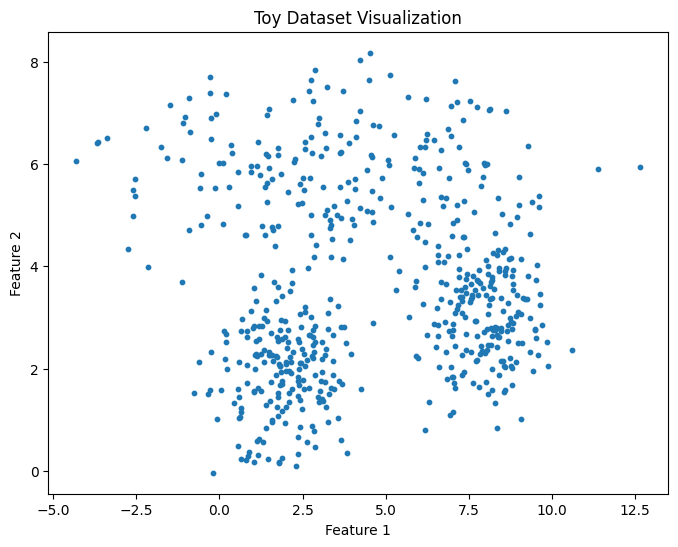

In [210]:
dataset3 = generate_dataset3()
visualize_dataset(dataset=dataset3, ordNumberOfAssignment=3)

### Task 3.2.
- Use Numpy only to implement the K-means method for finding three clusters from the toy dataset.
- Train this K-means with EM method.

In [211]:
def implement_kMeans_assignment3(dataset: list[list[float]], numberOfClusters: int = 3, max_iterations: int = 100) -> dict:

    # Step 1: Initialize centroids randomly
    initial_centroid_indices = random.sample(range(len(dataset)), numberOfClusters)
    
    clusters = {}
    for i, idx in enumerate(initial_centroid_indices):
        clusters[i] = {
            'centroid': list(dataset[idx]),  # Make a copy of the initial point
            'points': []                     # Empty list to store assigned points
        }

    # Iterate until convergence or max_iterations
    for iteration in range(max_iterations):
        # Store old centroids to check for convergence
        old_centroids = {k: list(v['centroid']) for k, v in clusters.items()} 

        # Step 2a: Assignment Step - Assign each data point to the nearest cluster
        new_assignments = {i: [] for i in range(numberOfClusters)}
        
        for datapoint in dataset:
            cluster_id = find_nearestCluster(datapoint, clusters)
            new_assignments[cluster_id].append(datapoint)
        
        # Step 2b: Update Step - Recalculate centroids
        converged = True
        for cluster_id, points_in_cluster in new_assignments.items():
            if points_in_cluster:  # Only update if the cluster has points
                new_centroid = update_latestCentroid(points_in_cluster)
                # Check for convergence
                if calculate_distance(old_centroids[cluster_id], new_centroid) > 1e-6:
                    converged = False
                clusters[cluster_id]['centroid'] = new_centroid
            # If cluster is empty, its centroid remains the same from the previous iteration
            # This 'pass' ensures its old centroid is kept, and won't affect `converged` unless it had moved
            else:
                pass 
                
            # Update the points list in the main clusters dictionary
            clusters[cluster_id]['points'] = points_in_cluster

        # Step 2c: Check for convergence
        if converged:
            print(f"K-Means converged after {iteration + 1} iterations.")
            break
    else:
        print(f"K-Means reached maximum iterations ({max_iterations}) without converging.")

    # The 'clusters' dictionary is already in the desired structure.
    return clusters

In [212]:
cluster3 = implement_kMeans_assignment3(dataset=dataset3, numberOfClusters=3)
cluster3

K-Means converged after 26 iterations.


{0: {'centroid': [np.float64(1.921546383361109),
   np.float64(1.946644313134271)],
  'points': [array([0.87350429, 0.30007142]),
   array([2.47027137, 1.21814821]),
   array([3.26021314, 3.08546065]),
   array([1.07994514, 2.26567961]),
   array([2.70337237, 1.61790033]),
   array([0.63569569, 2.74167096]),
   array([1.73317093, 1.24023787]),
   array([2.06566536, 2.74856045]),
   array([1.29960957, 0.55469463]),
   array([1.04503908, 2.83454957]),
   array([0.17382827, 2.19294922]),
   array([1.88164965, 1.6913961 ]),
   array([1.74896964, 2.53067717]),
   array([0.58554506, 2.1288282 ]),
   array([2.8775114 , 0.46618237]),
   array([1.89372339, 0.2527649 ]),
   array([2.82491743, 2.4697489 ]),
   array([1.57135229, 2.261459  ]),
   array([2.57783275, 3.10200512]),
   array([2.9942168 , 1.35598811]),
   array([1.51544241, 1.37030339]),
   array([3.64383031, 0.61307019]),
   array([0.55004689, 0.4817217 ]),
   array([1.42761446, 2.92887232]),
   array([2.00047622, 2.09722624]),
   arr

C:\Users\VICTUS\AppData\Local\Temp\ipykernel_1740\591568061.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(clusters))  # Get distinct colors


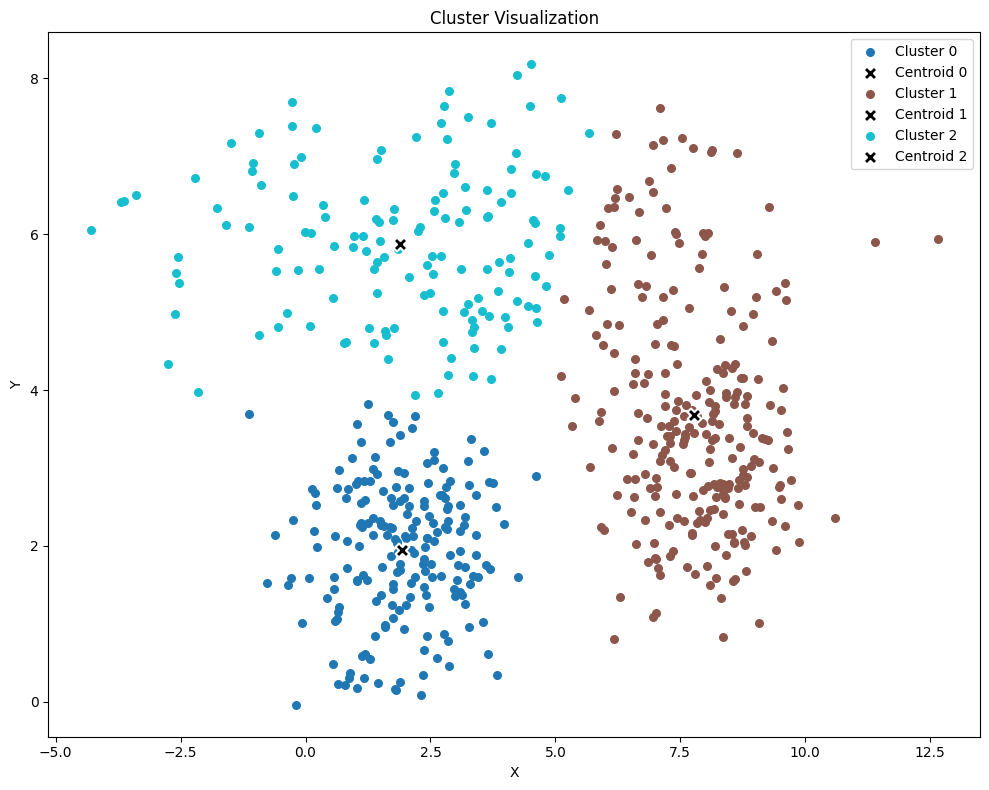

In [213]:
visualize_clusters(clusters=cluster3, ordNumberOfAssignment=3)

### Task 3.3. 
Comment on the effect of the cluster with $\mathcal{N}((3,6), \Sigma_2)$ on K-means performance

#### My comment

K-means works best when clusters are roughly spherical and about the same size because it groups points based on their distance to the nearest cluster center.

In this dataset, the third cluster is stretched out, especially along the x-axis, making it much wider than the others. Because of this, some points in that cluster might actually be closer to the centers of other clusters, even though they belong to the elongated cluster.

This can lead to errors where points get assigned to the wrong cluster. Also, since the cluster is spread out unevenly, the centroid (or center) found by K-means might end up closer to the middle of the dense part, which doesn't fully capture the cluster’s true shape and spread.

In short, because this cluster is elongated and has very different variance compared to the others, K-means struggles to group the points correctly. It tends to perform worse when clusters aren’t nice and round or when their sizes and shapes vary a lot.